In [3]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
mpl.use('Agg') # run matplotlib without X server (GUI)
import matplotlib.pyplot as plt
%matplotlib inline

from keras_wrapper.dataset import Dataset, saveDataset, loadDataset
from keras_wrapper.cnn_model import CNN_Model, loadModel, saveModel
from keras_wrapper.ecoc_classifier import ECOC_Classifier
from keras_wrapper.stage import Stage
from keras_wrapper.staged_network import Staged_Network, saveStagedModel, loadStagedModel
from keras_wrapper.utils import *

from localization_utilities import *
from main import *
from nms.gpu_nms import gpu_nms
from nms.cpu_nms import cpu_nms

from keras.models import Sequential, Graph, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.advanced_activations import PReLU

# Import Selective Search code
selsearch_root = '/home/lifelogging/code/selective_search'
import sys
sys.path.insert(0, selsearch_root)
import sel_search

import os
import logging
import copy
from operator import add
import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
from skimage.transform import resize

logging.basicConfig(level=logging.DEBUG, format='[%(asctime)s] %(message)s', datefmt='%d/%m/%Y %H:%M:%S')

In [4]:
# Path to the produced evaluation measures
path_data = '/media/HDD_2TB/marc/FoodDetection_keras_Data/CAMs_v2_test_ego'

# Load list of classes
path_classes = '/media/HDD_2TB/DATASETS/EgocentricFood_recognition/classes.txt'
classes = []
with open(path_classes, 'r') as list_c:
    for line in list_c:
        line = line.rstrip('\n')
        line = line.rstrip('\r')
        classes.append(line)

In [5]:
path_data_val = '/media/HDD_2TB/marc/FoodDetection_keras_Data/CAMs_v2_val_ego'

# Load best validation params (Part 1/3)
rec_1 = np.load(path_data_val+'/recalls_backup_350_GAP.npy')
pre_1 = np.load(path_data_val+'/precisions_backup_350_GAP.npy')
acc_1 = np.load(path_data_val+'/accuracies_backup_350_GAP.npy')
# [per_heat, size_res, box_exp, iou, n_bb] for each test
params_1 = np.load(path_data_val+'/params_cross_val_backup_350_GAP.npy')


# Load best validation params (Part 2/3)
rec_2 = np.load(path_data_val+'/recalls_backup_init_351_fin_550_550_GAP.npy')
pre_2 = np.load(path_data_val+'/precisions_backup_init_351_fin_550_550_GAP.npy')
acc_2 = np.load(path_data_val+'/accuracies_backup_init_351_fin_550_550_GAP.npy')
# [per_heat, size_res, box_exp, iou, n_bb] for each test
params_2 = np.load(path_data_val+'/params_cross_val_backup_init_351_fin_550_550_GAP.npy')


# Load best validation params (Part 3/3)
rec_3 = np.load(path_data_val+'/recalls_backup_init_551_fin_750_750_GAP.npy')
pre_3 = np.load(path_data_val+'/precisions_backup_init_551_fin_750_750_GAP.npy')
acc_3 = np.load(path_data_val+'/accuracies_backup_init_551_fin_750_750_GAP.npy')
# [per_heat, size_res, box_exp, iou, n_bb] for each test
params_3 = np.load(path_data_val+'/params_cross_val_backup_init_551_fin_750_750_GAP.npy')


##### join tests
rec = np.array(list(rec_1) + list(rec_2) + list(rec_3))
pre = np.array(list(pre_1) + list(pre_2) + list(pre_3))
acc = np.array(list(acc_1) + list(acc_2) + list(acc_3))
params = np.array(list(params_1) + list(params_2) + list(params_3))

## Choose best combination of parameters

In [6]:
# Get test settings with best average recall when comparing all IoU thresholds
len_sequence_IoU = 6
valid = acc.shape[0]-acc.shape[0]%len_sequence_IoU

rec__ = np.reshape(acc[:valid], (valid/6,6))
best_ind = np.argmax(np.mean(rec__, axis=1))*6
print rec[best_ind:best_ind+len_sequence_IoU]
print best_ind

print "Best test position: " + str(best_ind)
print "Best recall: " +str(rec[best_ind])
print "Best accuracy: " +str(acc[best_ind])
print "Best params:" 
print "[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]"
print params[best_ind]

best_params = params[best_ind]

[ 0.04724847  0.01889939  0.0077821   0.00166759  0.          0.        ]
360
Best test position: 360
Best recall: 0.047248471373
Best accuracy: 0.035446205171
Best params:
[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]
[  6.00000000e-01   6.00000000e-02   2.00000000e-01   5.00000000e-01
   9.99900000e+03]


In [7]:
path_imgs = '/media/HDD_2TB/DATASETS/EgocentricFood'
test_list = 'test_list.txt'

# CAMs path
#maps_dir = '/media/HDD_2TB/marc/FoodDetection_keras_Data/CAMs_test_ego'
maps_dir = '/media/HDD_2TB/marc/FoodDetection_keras_Data/CAMs_v2_test_ego'

# Recognition model
model_path_rec = '/media/HDD_2TB/CNN_MODELS/GoogleNet_EgocentricFood/finetuning_Food101_NoFood'
iter_rec = 9000
n_classes = 10

In [22]:
# Load dataset for pre-processing test images
ds = loadDataset('Datasets/Dataset_FoodVsNoFood.pkl')
# Load UEC detection test set
[ds, samples_detection] = loadUECDetectionTest(ds, path_imgs, test_list)
# Load predictions from GAP model
predictions = np.load(maps_dir+'/predictions.npy')

In [29]:
all_ids = samples_detection['all_ids']

In [26]:
# Load recognition model
#net = None # not applying recognition right now
net = loadModel(model_path_rec, iter_rec)

#### Test with best params and increasing the number of picked samples at each iteration for computing the curve

In [37]:
len(samples_detection['all_ids'])

1355

In [41]:
parameters = dict()
parameters['percentage_heat'] = best_params[0]
parameters['size_restriction'] = best_params[1]+0.001
parameters['box_expansion'] = best_params[2]
parameters['IoU'] = best_params[3]

# Best params UECFood256 GAP v2
# parameters = {'n_bboxes': 9999, 'box_expansion': 1.0, 'IoU': 0.5, 
# 'size_restriction': 0.10100000000000001, 'percentage_heat': 0.60000000000000009}
parameters['percentage_heat'] = 0.6
parameters['size_restriction'] = 0.1+0.001
parameters['box_expansion'] = 1.0

iou_values = np.arange(0.5,1.01,0.1)
#iou_values = [0.5]
#n_bboxes = [1,2,20]
n_bboxes = [999]


#samp_det = samples_detection
#samp_det['all_ids'] = []
#for i_ in range(50):
#    samp_det['all_ids'].append(all_ids[i_])


# Iterate picking one more samples each iteration and use the pre-calculated reports
list_measures = []
list_measures_classes = []
report_classes = None
for iou in iou_values:
    for nbb in n_bboxes:
        parameters['n_bboxes'] = nbb
        parameters['IoU'] = iou
        print 'parameters = '+str(parameters)
        [general_measures, class_measures, report_classes] = computePrecisionRecall(net, n_classes, ds, maps_dir, \
                                                                         samples_detection, predictions, \
                                                                         parameters, detect_type='GAP', report_all=report_classes)
        print general_measures
        print
        list_measures.append(general_measures)
        #[prec_classes, rec_classes, acc_classes, total_GT_classes, total_pred_classes] = class_measures
        list_measures_classes.append(class_measures)

parameters = {'n_bboxes': 999, 'box_expansion': 1.0, 'IoU': 0.5, 'size_restriction': 0.101, 'percentage_heat': 0.6}
[0.04490177736202058, 0.03644646924829157, 0.020530367835757058, 2634, 2138]

parameters = {'n_bboxes': 999, 'box_expansion': 1.0, 'IoU': 0.59999999999999998, 'size_restriction': 0.101, 'percentage_heat': 0.6}
[0.029466791393826006, 0.023917995444191344, 0.013378636653217243, 2634, 2138]

parameters = {'n_bboxes': 999, 'box_expansion': 1.0, 'IoU': 0.69999999999999996, 'size_restriction': 0.101, 'percentage_heat': 0.6}
[0.021515434985968196, 0.017463933181473046, 0.00973338975878121, 2634, 2138]

parameters = {'n_bboxes': 999, 'box_expansion': 1.0, 'IoU': 0.79999999999999993, 'size_restriction': 0.101, 'percentage_heat': 0.6}
[0.01028999064546305, 0.008352315869400152, 0.0046315789473684215, 2634, 2138]

parameters = {'n_bboxes': 999, 'box_expansion': 1.0, 'IoU': 0.89999999999999991, 'size_restriction': 0.101, 'percentage_heat': 0.6}
[0.00608044901777362, 0.004935459377372

## Use Selective Search for generating candidates

In [7]:
# Path to the produced evaluation measures
selpath_data = '/media/HDD_2TB/marc/FoodDetection_keras_Data/SelSearch_test_ego'

# Load all the necessary data
detect_type = 'SelSearch'

selprec = np.load(selpath_data+'/precisions_'+detect_type+'.npy')
selrec = np.load(selpath_data+'/recalls_'+detect_type+'.npy')
selacc = np.load(selpath_data+'/accuracies_'+detect_type+'.npy')
selnGT = np.load(selpath_data+'/num_GT_'+detect_type+'.npy')
selnPred = np.load(selpath_data+'/num_predictions_'+detect_type+'.npy')

selprec_c = np.load(selpath_data+'/precisions_classes_'+detect_type+'.npy')
selrec_c = np.load(selpath_data+'/recalls_classes_'+detect_type+'.npy')
selacc_c = np.load(selpath_data+'/accuracies_classes_'+detect_type+'.npy')
selnGT_c = np.load(selpath_data+'/num_GT_classes_'+detect_type+'.npy')
selnPred_c = np.load(selpath_data+'/num_predictions_classes_'+detect_type+'.npy')


# [per_heat, size_res, box_exp, iou, n_bb] for each test
selparams = np.load(selpath_data+'/params_cross_val_'+detect_type+'.npy')

# [predicted_bboxes, predicted_Y, predicted_scores, GT_bboxes, GT_Y] for each image
selreports = np.load(selpath_data+'/reports_'+detect_type+'.npy') 

In [42]:
print selnPred
selbest_ind = np.argmax(selacc)
print "Best test position: " + str(selbest_ind)
print "Best accuracy: " +str(selacc[selbest_ind])
print "Best precision: " +str(selprec[selbest_ind])
print "Best recall: " +str(selrec[selbest_ind])
print "Best params:" 
print "[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]"
print selparams[selbest_ind]

selbest_params = selparams[selbest_ind]
selbest_reports = selreports[selbest_ind]

NameError: name 'selnPred' is not defined

In [17]:
parameters = dict()
parameters['percentage_heat'] = 0
parameters['size_restriction'] = 0
parameters['box_expansion'] = 0
#parameters['IoU'] = selbest_params[3]
iou_values = np.arange(0.5, 1.01, 0.1)
#n_bboxes = np.arange(0,1000,1)
n_bboxes = [99999]

# Iterate picking one more samples each iteration and use the pre-calculated reports
sellist_measures = []
for iou in iou_values:
    for nbb in n_bboxes:
        parameters['n_bboxes'] = nbb
        parameters['IoU'] = iou
        print 'parameters = '+str(parameters)
        [selgeneral_measures, selclass_measures, selreport] = computePrecisionRecall(net, n_classes, ds, selpath_data, \
                                                                         samples_detection, [], \
                                                                         parameters, detect_type='SelSearch')
                                                                         #, report_all=best_reports)
        print selgeneral_measures
        print 
        sellist_measures.append(selgeneral_measures)
        #[selprec, selrec, selacc, seltotal_GT, seltotal_pred] = selgeneral_measures
        #[selprec_classes, selrec_classes, selacc_classes, seltotal_GT_classes, seltotal_pred_classes] = selclass_measures

parameters = {'box_expansion': 0, 'n_bboxes': 99999, 'size_restriction': 0, 'IoU': 0.5, 'percentage_heat': 0}


KeyboardInterrupt: 

## Use Faster-RCNN for generating candidates

In [20]:
# Path to the produced evaluation measures
fastpath_data = '/media/HDD_2TB/marc/FoodDetection_keras_Data/FasterRCNN_test_ego'

# Load all the necessary data
detect_type = 'FasterRCNN'

fastprec = np.load(fastpath_data+'/precisions_'+detect_type+'.npy')
fastrec = np.load(fastpath_data+'/recalls_'+detect_type+'.npy')
fastacc = np.load(fastpath_data+'/accuracies_'+detect_type+'.npy')
fastnGT = np.load(fastpath_data+'/num_GT_'+detect_type+'.npy')
fastnPred = np.load(fastpath_data+'/num_predictions_'+detect_type+'.npy')

fastprec_c = np.load(fastpath_data+'/precisions_classes_'+detect_type+'.npy')
fastrec_c = np.load(fastpath_data+'/recalls_classes_'+detect_type+'.npy')
fastacc_c = np.load(fastpath_data+'/accuracies_classes_'+detect_type+'.npy')
fastnGT_c = np.load(fastpath_data+'/num_GT_classes_'+detect_type+'.npy')
fastnPred_c = np.load(fastpath_data+'/num_predictions_classes_'+detect_type+'.npy')


# [per_heat, size_res, box_exp, iou, n_bb] for each test
fastparams = np.load(fastpath_data+'/params_cross_val_'+detect_type+'.npy')

# [predicted_bboxes, predicted_Y, predicted_scores, GT_bboxes, GT_Y] for each image
fastreports = np.load(fastpath_data+'/reports_'+detect_type+'.npy') 

In [21]:
print fastnPred
fastbest_ind = np.argmax(fastacc)
print "Best test position: " + str(fastbest_ind)
print "Best accuracy: " +str(fastacc[fastbest_ind])
print "Best precision: " +str(fastprec[fastbest_ind])
print "Best recall: " +str(fastrec[fastbest_ind])
print "Best params:" 
print "[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]"
print fastparams[fastbest_ind]

fastbest_params = fastparams[fastbest_ind]
fastbest_reports = fastreports[fastbest_ind]

[29330 29330 29330 29330 29330 29330]
Best test position: 0
Best accuracy: 0.0471073838695
Best precision: 0.0490282986703
Best recall: 0.545937737282
Best params:
[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   5.00000000e-01
   9.99900000e+03]


### Plot some examples

In [ ]:
#id_img = 2376
#windows = sel_search.get_windows([samples_detection['list_imgs'][id_img]])
#windows = np.load(selpath_data +'/'+ samples_detection['all_ids'][id_img] +'_windows.npy')

/media/HDD_2TB/DATASETS/EgocentricFood/7/4595.jpg


NameError: name 'reports' is not defined

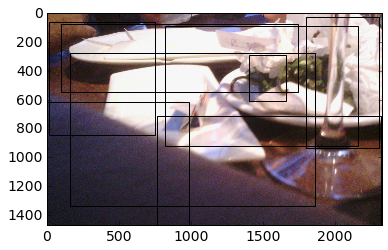

In [22]:
id_img = 1230
#id_img = 185


print samples_detection['list_imgs'][id_img]
im = misc.imread(samples_detection['list_imgs'][id_img])
ax = plt.subplot(1,1,1)
plt.imshow(im)

# Selective Search result
#### BEWERE! we are using stored reports instead of the last output
#selreport = selreports[selbest_ind]
#for box in selreport[id_img][0]:
#    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='red'))

    
# Faster-RCNN
#### BEWERE! we are using stored reports instead of the last output
fastreport = fastreports[fastbest_ind]
for box in fastreport[id_img][0]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='black'))
    
    
    
# FoodVsNoFood GoogleNet-GAP result
#### BEWERE! we are using stored reports instead of the last output
report = reports[best_ind]
print report[id_img]
for box in report[id_img][0]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
    
# Ground Truth
for box in report[id_img][3]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))

/media/HDD_2TB/DATASETS/EgocentricFood/3/0399.jpg


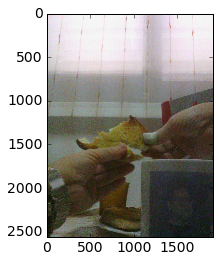

In [54]:
id_img = 119

print samples_detection['list_imgs'][id_img]
im = misc.imread(samples_detection['list_imgs'][id_img])
ax = plt.subplot(1,1,1)
plt.imshow(im)

/media/HDD_2TB/DATASETS/EgocentricFood/9/0001.jpg
[[[1382.3, 1122.9000000000001, 1918.7, 2591], [40.799999999999997, 0, 379.20000000000005, 1228.8], [47.700000000000003, 1371.4000000000001, 303.30000000000001, 2470.5999999999999], [1259.0999999999999, 1077.0999999999999, 1845.8999999999999, 1999.8999999999999], [0, 871.5, 436.80000000000001, 2401.5], [30.199999999999996, 115.8, 435.80000000000001, 862.19999999999993], [551.10000000000002, 0, 1943, 648.0], [136.69999999999999, 364.19999999999999, 548.29999999999995, 1093.8], [1655.0999999999999, 1660.2, 1943, 2413.7999999999997], [10.899999999999999, 1863.0999999999999, 396.09999999999997, 2461.9000000000001], [1536.7, 79.299999999999997, 1852.3, 1263.7], [1262.7, 1368.0999999999999, 1842.3, 1978.8999999999999], [84.5, 563.39999999999998, 606.5, 1338.6000000000001], [324.80000000000001, 558.0, 987.19999999999993, 1122.0], [1312.7, 1137.0999999999999, 1760.3, 1699.8999999999999], [0, 1213.4000000000001, 384.0, 2591], [1597.9000000000001,

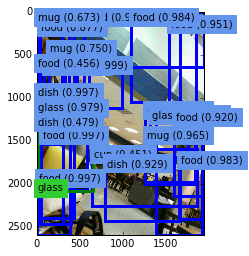

In [15]:
id_img = 28
id_img = 45
id_img = 104
id_img = 157
id_img = 202
id_img = 223
id_img = 450
id_img = 564

id_img = 0

print samples_detection['list_imgs'][id_img]
im = misc.imread(samples_detection['list_imgs'][id_img])
ax = plt.subplot(1,1,1)
plt.imshow(im)

# Selective Search result
#### BEWERE! we are using stored reports instead of the last output
#selreport = selreports[selbest_ind]
#for box in selreport[id_img][0]:
#    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3],-box[1] facecolor="none", edgecolor='red'))

# FoodVsNoFood GoogleNet-GAP result
print report_classes[id_img]
for box, y, prob in zip(report_classes[id_img][0], report_classes[id_img][1], report_classes[id_img][2]):
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
    #ax.text(box[0]+10, box[1]+25, classes[y] + ' (' + str(prob)[:5] + ')', backgroundcolor='cornflowerblue')
    ax.text(box[0]+20, box[1]+100, classes[y] + ' (' + str(prob)[:5] + ')', backgroundcolor='cornflowerblue')
    
# Ground Truth
for box, y in zip(report_classes[id_img][3], report_classes[id_img][4]):
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))
    ax.text(box[0], box[3], classes[y], backgroundcolor='limegreen')

519
/media/HDD_2TB/DATASETS/EgocentricFood/1/1879.jpg
[[[1176.0, 693.20000000000005, 2400.0, 1614.8000000000002]], [7], [0.9999994], [[14.5, 58.5, 278.5, 650.5], [1746.5, 642.5, 2118.5, 1330.5], [210.5, 494.5, 974.5, 930.5], [746.5, 926.5, 2578.5, 1778.5], [1938.5, 998.5, 2254.5, 1358.5]], [1, 1, 7, 7, 9]]
520
/media/HDD_2TB/DATASETS/EgocentricFood/7/1887.jpg
[[[0, 175.39999999999998, 2591, 1646.6000000000001]], [7], [0.99995708], [[22.5, 550.5, 1578.5, 1590.5], [874.5, 442.5, 1570.5, 902.5], [1358.5, 858.5, 2590.5, 1630.5], [390.5, 86.5, 906.5, 778.5]], [7, 7, 7, 9]]
521
/media/HDD_2TB/DATASETS/EgocentricFood/1/1890.jpg
[[[570.89999999999998, 838.89999999999998, 2591, 1776.1000000000001]], [7], [1.0], [[2222.5, 22.5, 2574.5, 1090.5], [1754.5, 90.5, 2206.5, 1074.5], [758.5, 846.5, 2558.5, 1730.5]], [1, 4, 7]]
522
/media/HDD_2TB/DATASETS/EgocentricFood/3/1892.jpg
[[], [], [], [[66.5, 462.5, 410.5, 806.5], [1522.5, 954.5, 1730.5, 1238.5]], [3, 9]]
523
/media/HDD_2TB/DATASETS/EgocentricFo

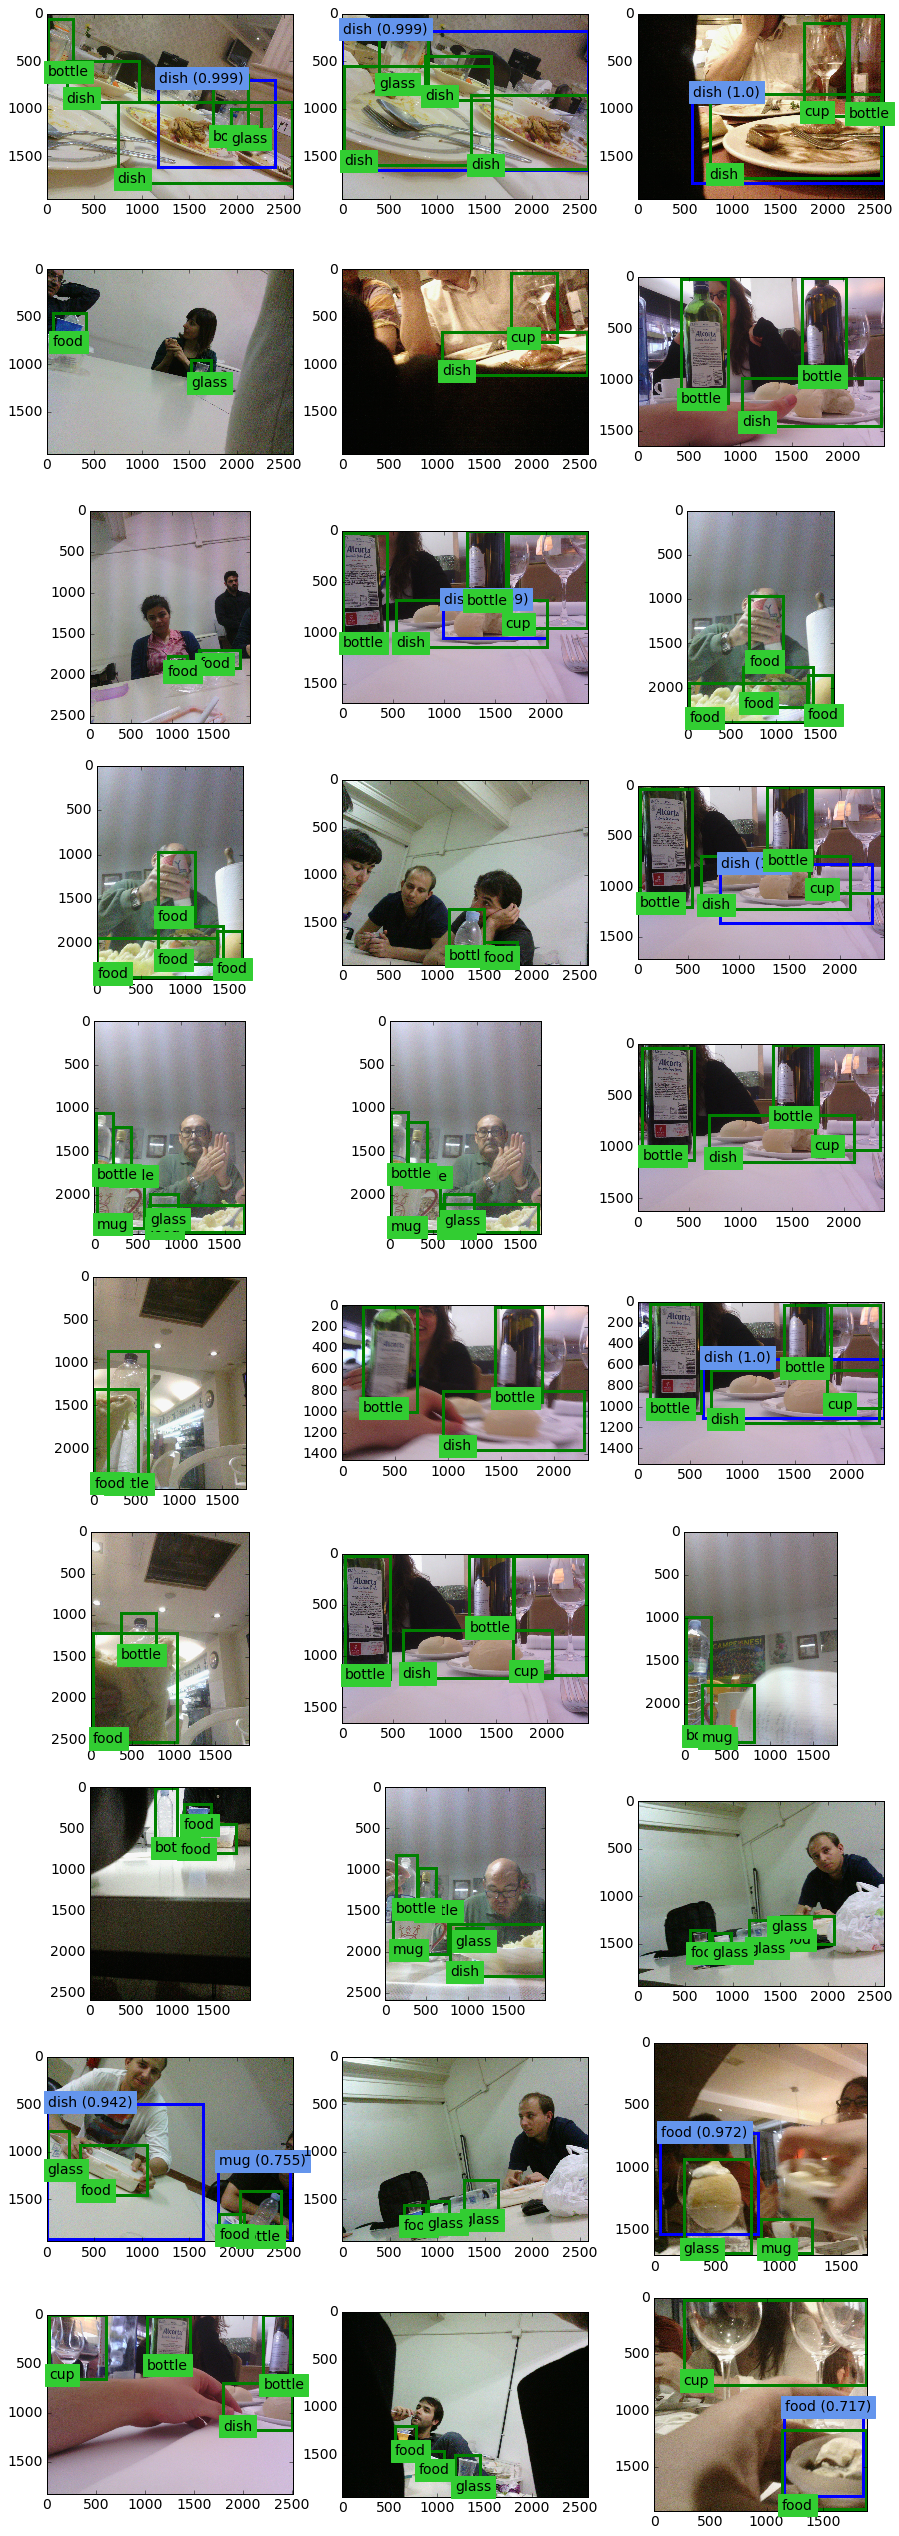

In [64]:
id_img = 518
found = 0

f = plt.figure(1)
f.set_size_inches(15, 15*3)
while(found < 30):
    if(len(report_classes[id_img][4])) > 1:
        found += 1
        print id_img
        print samples_detection['list_imgs'][id_img]
        im = misc.imread(samples_detection['list_imgs'][id_img])
        ax = plt.subplot(10,3,found)
        plt.imshow(im)

        # Selective Search result
        #### BEWERE! we are using stored reports instead of the last output
        #selreport = selreports[selbest_ind]
        #for box in selreport[id_img][0]:
        #    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3],-box[1] facecolor="none", edgecolor='red'))

        # FoodVsNoFood GoogleNet-GAP result
        print report_classes[id_img]
        for box, y, prob in zip(report_classes[id_img][0], report_classes[id_img][1], report_classes[id_img][2]):
            ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
            ax.text(box[0]+10, box[1]+25, classes[y] + ' (' + str(prob)[:5] + ')', backgroundcolor='cornflowerblue')

        # Ground Truth
        for box, y in zip(report_classes[id_img][3], report_classes[id_img][4]):
            ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))
            ax.text(box[0], box[3], classes[y], backgroundcolor='limegreen')
        
    id_img += 1

#### Plot Recall/Precision/Accuracy vs IoU

In [19]:
sequence = [best_ind, best_ind+6]
selsequence = [selbest_ind, selbest_ind+6]
fastsequence = [fastbest_ind, fastbest_ind+6]

# Plot data
plt.plot([l[1] for l in list_measures], color='blue')
#plt.plot(rec[sequence[0]:sequence[1]], color='blue')
plt.plot(selrec[selsequence[0]:selsequence[1]], color='red')
plt.plot(fastrec[fastsequence[0]:fastsequence[1]], color='black')
plt.grid()

# Set Y labels
plt.ylabel('Recall')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

NameError: name 'selbest_ind' is not defined

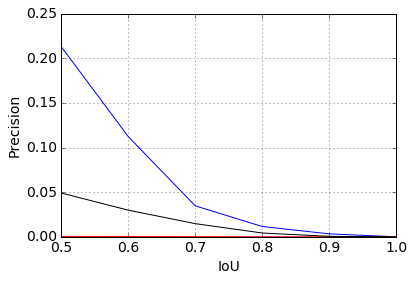

In [48]:
# Plot data
plt.plot([l[0] for l in list_measures], color='blue')
#plt.plot(pre[sequence[0]:sequence[1]], color='blue')
plt.plot(selprec[selsequence[0]:selsequence[1]], color='red')
plt.plot(fastprec[fastsequence[0]:fastsequence[1]], color='black')
plt.grid()

# Set Y labels
plt.ylabel('Precision')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

In [8]:
# Plot data
plt.plot([l[2] for l in list_measures], color='blue')
#plt.plot(acc[sequence[0]:sequence[1]], color='blue')
plt.plot(selacc[selsequence[0]:selsequence[1]], color='red')
plt.plot(fastacc[fastsequence[0]:fastsequence[1]], color='black')
plt.grid()

# Set Y labels
plt.ylabel('Accuracy')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

NameError: name 'list_measures' is not defined

## Detection methods time comparison (including image loading): SelSearch 0.8s per image, Faster-RCNN 0.2s per image, GAP 0.06s per image

In [33]:
print np.mean(list_measures_classes[0][0][1:]) # precision
print np.mean(list_measures_classes[0][1][1:]) # recall
print np.mean(list_measures_classes[0][2][1:]) # accuracy

0.17375040752
0.0872355226912
0.064061153594
